In [7]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import roc_curve,roc_auc_score
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [8]:
molecule_matrix = pd.read_csv('./Dataset/Molecule_matrix_mold2.csv',dtype={'CID':'str'})

In [9]:
CID = np.array(molecule_matrix['CID'])
label = np.array(molecule_matrix['outcome'])
molecule_matrix_ = np.array(molecule_matrix.iloc[:,1:molecule_matrix.shape[1]-1])

In [10]:
label[label=='active']=1
label[label=='inactive']=0
label = label.astype('int')

In [11]:
print(molecule_matrix_.shape)
print(Counter(label))

(302630, 648)
Counter({0: 301747, 1: 883})


In [12]:
ratio = {0:8000,1:883}
rus = RandomUnderSampler(ratio=ratio, replacement=False, return_indices=True)
x_resample, y_resample, indices = rus.fit_sample(molecule_matrix_,label)

In [13]:
x_train,x_test,y_train,y_test = train_test_split(x_resample,y_resample,test_size = 0.2)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train)

In [14]:
train = xgb.DMatrix(x_train,y_train)
val = xgb.DMatrix(x_val,y_val)
test = xgb.DMatrix(x_test,y_test)

In [15]:
# set the parameters for xgboost
scale = float(np.sum(y_resample==0)/np.sum(y_resample==1))
param = {'gamma':0.8,'max_depth':6,'objective':'binary:logistic','eval_metric':'auc','scale_pos_weight':scale}
num_round = 25
watchlist = [(val,'eval'),(train,'train')]

In [16]:
# train the model
evals_result = dict()
bst = xgb.train(params=param,dtrain=train,num_boost_round=num_round,evals=watchlist,evals_result=evals_result)

[0]	eval-auc:0.739722	train-auc:0.870898
[1]	eval-auc:0.786996	train-auc:0.910555
[2]	eval-auc:0.806891	train-auc:0.925891
[3]	eval-auc:0.805441	train-auc:0.944644
[4]	eval-auc:0.806647	train-auc:0.95572
[5]	eval-auc:0.806798	train-auc:0.963798
[6]	eval-auc:0.811606	train-auc:0.970496
[7]	eval-auc:0.806716	train-auc:0.980018
[8]	eval-auc:0.804366	train-auc:0.985237
[9]	eval-auc:0.809163	train-auc:0.987598
[10]	eval-auc:0.807115	train-auc:0.990474
[11]	eval-auc:0.810088	train-auc:0.991683
[12]	eval-auc:0.810693	train-auc:0.993399
[13]	eval-auc:0.811141	train-auc:0.995819
[14]	eval-auc:0.810762	train-auc:0.997044
[15]	eval-auc:0.810407	train-auc:0.997268
[16]	eval-auc:0.810021	train-auc:0.9977
[17]	eval-auc:0.81215	train-auc:0.997863
[18]	eval-auc:0.810507	train-auc:0.998444
[19]	eval-auc:0.811116	train-auc:0.998618
[20]	eval-auc:0.809094	train-auc:0.998846
[21]	eval-auc:0.80895	train-auc:0.999291
[22]	eval-auc:0.810517	train-auc:0.999372
[23]	eval-auc:0.812963	train-auc:0.999588
[24]	ev

In [17]:
train_auc = evals_result['train']['auc']
eval_auc = evals_result['eval']['auc']

Text(0,0.5,'Area Under ROC curve')

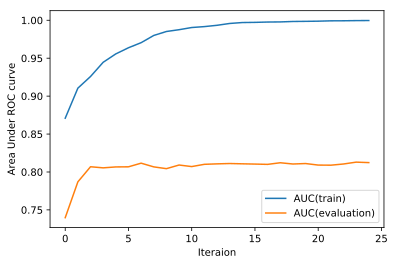

In [18]:
plt.plot(train_auc,label='AUC(train)')
plt.plot(eval_auc,label='AUC(evaluation)')
plt.legend()
plt.xlabel('Iteraion')
plt.ylabel('Area Under ROC curve')

In [21]:
# set the cut-off threshold to 0.4 
pred = bst.predict(test)
y_preds = [1 if p>0.4 else 0 for p in pred]

In [22]:
# metric measurement: 1). Accuracy 
label =  test.get_label()
print('Accuracy:', 1- np.mean(y_preds != label))

Accuracy: 0.856499718627


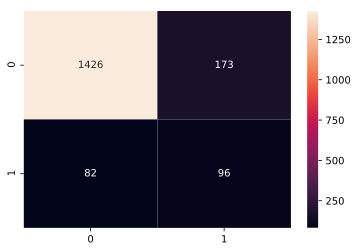

In [23]:
# 2). confustion matrix
cm = confusion_matrix(y_pred=y_preds,y_true=label)
sns.heatmap(cm,annot=True,fmt='d')

In [24]:
# 3). True positive rate and False negative rate
tn,fp,fn,tp = confusion_matrix(y_pred=y_preds,y_true=label).ravel()
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
print('True positive rate:', tpr)
print('False negative rate:', fnr)

True positive rate: 0.539325842697
False negative rate: 0.460674157303


In [25]:
# 4). auc
print('AUC:', roc_auc_score(y_true=label,y_score=pred))

AUC: 0.830223946146


In [26]:
# 5). ROC curve
fpr,tpr,thresholds = roc_curve(y_true=label,y_score=pred)

Text(0.5,1,'ROC curve')

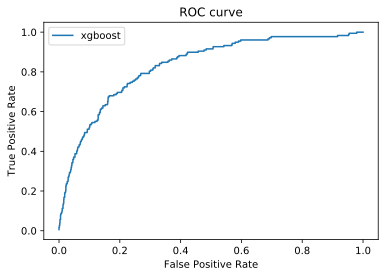

In [27]:
plt.plot(fpr,tpr,label='xgboost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC curve')

# BAGGING

In [120]:
class baggingXgboost:
    def __init__(self,x,y,boost_size=10):
        self.x = x
        self.y = y
        self.boost_size = boost_size
        self.boost = []
        
    def underSampleMajority(self,majority_multiplier=10):
        label = dict(Counter(self.y))
        ratio = {1:label[1],0:int(majority_multiplier*label[1])}
        rus = RandomUnderSampler(ratio=ratio, replacement=False)
        x_resample, y_resample = rus.fit_sample(self.x,self.y)
        return x_resample, y_resample
    
    def train(self,x,y):
        train = xgb.DMatrix(x,y)
        scale = float(np.sum(y == 0)/np.sum(y == 1))
        param = {'gamma':0.8,'max_depth':6,'objective':'binary:logistic','eval_metric':'auc','scale_pos_weight':scale}
        num_round = 25
        bst = xgb.train(params=param,dtrain=train,num_boost_round=num_round)
        self.boost.append(bst)
        
    def predict(self,test):
        bagging_result = np.zeros((self.boost_size,x_test.shape[0]))
        pred_result = np.zeros(x_test.shape[0])
        true = test.get_label()
        
        for i in range(self.boost_size):
            bst_i = self.boost[i]
            pred = bst_i.predict(test)
            pred_ =  [1 if p>0.4 else 0 for p in pred]
            bagging_result[i] = pred_
        
        col_sum = np.sum(bagging_result,axis=0)
        posi_indx = np.where(col_sum >= (self.boost_size/2))
        pred_result[posi_indx] = 1
        
        return true, pred_result
        

In [111]:
rand_indx = np.random.permutation(molecule_matrix_.shape[0])
molecule_matrix_rand = molecule_matrix_[rand_indx]
label_rand = label[rand_indx]

In [112]:
neg_indx = list(np.where(label_rand==0)[0][:1500])
post_indx = np.where(label_rand==1)[0][:150]

In [113]:
for p in post_indx:
    neg_indx.append(p)

In [114]:
x_test = molecule_matrix_rand[neg_indx]
y_test = label_rand[neg_indx]

In [115]:
train_indx = np.ones(molecule_matrix_rand.shape[0]).astype('bool')
train_indx[neg_indx] = False
x_train = molecule_matrix_rand[train_indx]
y_train = label_rand[train_indx]

In [116]:
test = xgb.DMatrix(x_test,y_test)

In [121]:
bsize = 20
bx = baggingXgboost(x_train,y_train,boost_size=bsize)

In [122]:
for b in range(bsize):
    x_resample,y_resample = bx.underSampleMajority()
    bx.train(x_resample,y_resample)

In [123]:
true, pred = bx.predict(test)

In [127]:
tn,fp,fn,tp = confusion_matrix(y_pred=pred,y_true=true).ravel()
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
print('True positive rate:', tpr)
print('False negative rate:', fnr)

True positive rate: 0.64
False negative rate: 0.36
